In [3]:
import math
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz, simps, cumtrapz

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Расчет

Некоторые константы

In [4]:
Q_EC_127Xe=0.662 #in MeV
Z_127Xe=54

g_a_g_v=1.297 #ratio of vector and axial coupling constants

BS05_OP_pep_ampl=1.42e8
pep_en=1.442 #MeV

Be384_en = 0.384 #Mev 
Be862_en = 0.862 #Mev

S_n = 7.246 #энергия отрыва нейтрона

total_GT = 53.54
#total_GT = 63

Функция для расчета порога реакции

In [5]:
def Q_k_func(E_k, Q_EC):
    #Считаем порог реакции, E_k - энергия возбужденного состояния в BGT
    #E_k in KeV
    return Q_EC+E_k/1000

Привиденная энергия вылетающего электрона: $\epsilon_e = \frac{E_{\nu}-Q_k}{m_e} + 1$

In [6]:
def e_e_func(E_nu, E_k, Q_EC):
    #Считаем привиденную энергию вылетающего электрона. Если энергия налетающего нейтрино E_nu
    #меньше порога, возвращаем 0 для обнуления итогового сечения
    #E_nu in MeV
    q=Q_k_func(E_k, Q_EC) #порог реакции
    if E_nu>q: return 1+(E_nu-q)/0.511
    else: return 0 

Привиденный импульс электрона: $\pi_e=\sqrt{\epsilon_e^2 -1}$

In [7]:
def Pi_e_func(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    if e_e>1: return math.sqrt(e_e**2 - 1)
    else: return 0

In [8]:
def integrate_func(a, b, x, y):
    return np.sum( np.interp(x=np.arange(a, b, 0.001), xp=x, fp=y ) * 0.001 )

### Fermi-function from Numerical Tables for Beta-Decay and Electron Capture

Ферми функия из оцифрованных немецких таблиц. Считываем данные

In [9]:
Fermi_func_new_data = pd.read_excel('../../fermi_func_tables/from_1968/Z_54.ocr.xls', 
                                    parse_cols="A,B", decimal='.')
Fermi_func_new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
p       48 non-null float64
F0L0    48 non-null float64
dtypes: float64(2)
memory usage: 848.0 bytes


In [10]:
Fermi_func_new_data.head()

,p,F0L0
0,0.1,68.550
1,0.2,34.627
2,0.3,23.465
3,0.4,17.995
4,0.5,14.807


Функция для расчета интерполированного значения. В таблице дана зависимость от импульса вылетающего электрона. Переводим ее в зав-ть от энергии электрона

In [11]:
e_e3 = np.sqrt( np.square( Fermi_func_new_data['p'].values ) + 1 ) #энергия вылетающего электрона
def num_tables_func(x):
    #x in units of mc^2
    return np.interp(x=x, xp=e_e3, fp=Fermi_func_new_data['F0L0'].values )

### BS05_OP flux

In [12]:
BS05OP_Be = 4.84e9
BS05OP_pp = 5.99e10
BS05OP_pep = 1.42e8
BS05OP_hep = 7.93e3
BS05OP_B = 5.69e6
BS05OP_N = 3.07e8
BS05OP_0 = 2.33e8
BS05OP_F = 5.84e6

In [13]:
BP98_Be = 4.80e9
BP98_pp = 5.94e10
BP98_pep = 1.39e8
BP98_hep = 2.10e3
BP98_B = 5.15e6 
BP98_N = 6.05e8
BP98_0 = 5.32e8
BP98_F = 6.33e6

In [14]:
BP98_OPAL92_Be = 4.94e9
BP98_OPAL92_pp = 5.92e10
BP98_OPAL92_pep = 1.39e8
BP98_OPAL92_hep = 2.08e3
BP98_OPAL92_B = 5.44e6 
BP98_OPAL92_N = 6.25e8
BP98_OPAL92_0 = 5.52e8
BP98_OPAL92_F = 6.59e6

In [15]:
#B16-GS98 - high metallicity
B16_GS98_Be = 4.93e9
B16_GS98_pp = 5.98e10
B16_GS98_pep = 1.44e8
B16_GS98_hep = 7.98e3
B16_GS98_B = 5.46e6 
B16_GS98_N = 2.78e8
B16_GS98_0 = 2.05e8
B16_GS98_F = 5.29e6

In [16]:
#B16-AGSS09met - low metallicity
B16_AGSS09met_Be = 4.50e9
B16_AGSS09met_pp = 6.03e10
B16_AGSS09met_pep = 1.46e8
B16_AGSS09met_hep = 8.25e3
B16_AGSS09met_B = 4.50e6 
B16_AGSS09met_N = 2.04e8
B16_AGSS09met_0 = 1.44e8
B16_AGSS09met_F = 3.26e6

In [17]:
step_all_fluxes = 0.001 #MeV
Energy_all_fluxes = np.arange(0,20,step_all_fluxes)

In [18]:
def return_flux(pp_ampl, hep_ampl, B_ampl, N_ampl, O_ampl, F_ampl, 
                energy_list = Energy_all_fluxes):
    pp = pd.read_excel('../Solar_neutrino_flux/pp.xls')
    b8 = pd.read_excel('../Solar_neutrino_flux/b8.xls')
    hep = pd.read_excel('../Solar_neutrino_flux/hep.xls')
    n13 = pd.read_excel('../Solar_neutrino_flux/n13.xls')
    o15 = pd.read_excel('../Solar_neutrino_flux/o15.xls')
    f17 = pd.read_excel('../Solar_neutrino_flux/f17.xls')

    flux = {
        'pp':np.interp(x=Energy_all_fluxes, xp=pp['Energy'].values, 
                       fp=pp['Probability'].values * pp_ampl ),
        'b8':np.interp(x=Energy_all_fluxes, xp=b8['Energy'].values, 
                       fp=b8['Probability'].values * B_ampl ),
        'hep':np.interp(x=Energy_all_fluxes, xp=hep['Energy'].values, 
                       fp=hep['Probability'].values * hep_ampl ),
        'n13':np.interp(x=Energy_all_fluxes, xp=n13['Energy'].values, 
                       fp=n13['Probability'].values * N_ampl ),
        'o15':np.interp(x=Energy_all_fluxes, xp=o15['Energy'].values, 
                       fp=o15['Probability'].values * O_ampl ),
        'f17':np.interp(x=Energy_all_fluxes, xp=f17['Energy'].values, 
                       fp=f17['Probability'].values * F_ampl ),
    }
    return flux

In [19]:
BS05OP_flux = return_flux(pp_ampl=BS05OP_pp, 
                          hep_ampl=BS05OP_hep,
                          B_ampl=BS05OP_B,
                          N_ampl=BS05OP_N,
                          O_ampl=BS05OP_0,
                          F_ampl=BS05OP_F)

BP98_flux = return_flux(pp_ampl=BP98_pp, 
                          hep_ampl=BP98_hep,
                          B_ampl=BP98_B,
                          N_ampl=BP98_N,
                          O_ampl=BP98_0,
                          F_ampl=BP98_F)

BP98_OPAL92_flux = return_flux(pp_ampl=BP98_OPAL92_pp, 
                          hep_ampl=BP98_OPAL92_hep,
                          B_ampl=BP98_OPAL92_B,
                          N_ampl=BP98_OPAL92_N,
                          O_ampl=BP98_OPAL92_0,
                          F_ampl=BP98_OPAL92_F)

B16_GS98_flux = return_flux(pp_ampl=B16_GS98_pp, 
                          hep_ampl=B16_GS98_hep,
                          B_ampl=B16_GS98_B,
                          N_ampl=B16_GS98_N,
                          O_ampl=B16_GS98_0,
                          F_ampl=B16_GS98_F)

B16_AGSS09met_flux = return_flux(pp_ampl=B16_AGSS09met_pp, 
                          hep_ampl=B16_AGSS09met_hep,
                          B_ampl=B16_AGSS09met_B,
                          N_ampl=B16_AGSS09met_N,
                          O_ampl=B16_AGSS09met_0,
                          F_ampl=B16_AGSS09met_F)

### Cross-section and total rate

Сечение по Иджири $\sigma_k={(10^{-44}\ cm^2)}\times 1.597\cdot \epsilon_e \pi_e m_e^2 F(Z,E_e) [B(F)_k + (\frac{g_a}{g_v})^2 B(GT)_k] $ 

In [20]:
g_a_g_v_square = math.pow(g_a_g_v,2)
m_e_square = math.pow(0.511,2)

In [21]:
#расчет сечения до энергии возбуждения 5 МэВ
def sigma_k_less5(E_nu, E_k, BGT_k, Z, Q_EC):
    #E_k in kev
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC) #энергия вылетающего электрона
    Pi_e=Pi_e_func(e_e) #его импульс
    F_col=num_tables_func(e_e) #значение ферм-функции при такой энергии
    return 1.597*m_e_square*e_e*Pi_e*F_col*g_a_g_v_square*BGT_k

In [22]:
#функция расчета свертки сечения с потоком
def rate_calc(sigma, fluxes_dict, energies_array, step, func_pep_ampl = BS05OP_pep, func_Be_ampl = BS05OP_Be):
    
    #const = 1.597*math.pow(10,-44)
    const = math.pow(10,-44)

    sigma_total = np.array(sigma) * const
    
    rate_total = 0
    
    for elem in list(fluxes_dict.keys()):
        rate = sum(fluxes_dict[elem]*sigma_total*step) * math.pow(10,36)
        print(elem, ' ', rate)
        rate_total+=rate
        
    sigma_pep = np.interp(pep_en, xp=energies_array, fp=sigma_total)
    rate_pep = func_pep_ampl*sigma_pep*math.pow(10,36)
    print('pep', ' ', rate_pep)
    rate_total+=rate_pep
    
    sigma_Be384 = np.interp(Be384_en, xp=energies_array, fp=sigma_total)
    rate_Be384 = 0.103*func_Be_ampl*sigma_Be384*math.pow(10,36) #отношение из книжки бакала 
    
    sigma_Be862 = np.interp(Be862_en, xp=energies_array, fp=sigma_total)
    rate_Be862 = 0.897*func_Be_ampl*sigma_Be862*math.pow(10,36)
    rate_Be = rate_Be384 + rate_Be862
    
    print('Be', ' ', rate_Be)
    rate_total+=rate_Be
    
    print('rate_total',' ', rate_total)

### Расчет сечения с учетом графика из статьи 1999 года


In [23]:
best_fit = pd.read_excel('127Xe_gauss.xls')
best_fit.head()
#best_fit = pd.read_csv('2pigmy_best_fit-SDR-IAS-QFC.csv')

,"Ex, MeV",y
0,0.350987,0.000603
1,0.434621,0.000786
2,0.482412,0.000911
3,0.589942,0.001261
4,0.733315,0.001911


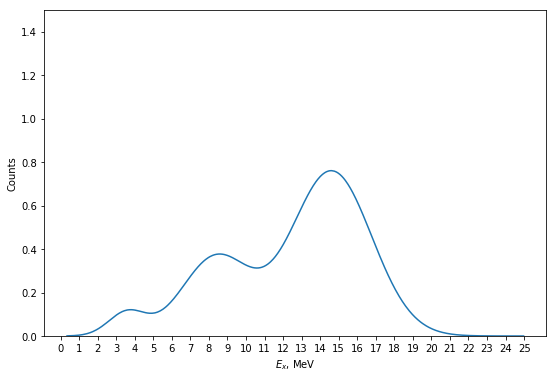

In [24]:
plt.figure(figsize=(9,6))
plt.plot(best_fit['Ex, MeV'].values, best_fit['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
plt.ylim(0,1.5)
plt.xticks(np.arange(0,26,1))
plt.show()

In [25]:
#функция для отрезки резонансов выше энергии отрыва
def border_func(x_data, y_data, border):
    a=np.where(x_data<border)
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))


def border_func2(x_data, y_data, border_l, border_r):
    a=np.where(x_data<border_r)
    b=np.where(x_data>border_l)
    temp_y = np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack((np.zeros((b[0][0])), temp_y[b]))

In [26]:
trapz(best_fit['y'].values, best_fit['Ex, MeV'].values)

6.057219427825755

(0, 20)

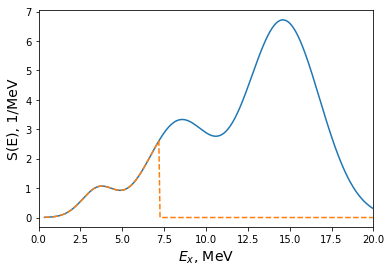

In [27]:
y = best_fit['y'].values / trapz(best_fit['y'].values, best_fit['Ex, MeV'].values) \
* total_GT

#y_best_fit_border = border_func(best_fit['x'].values, y_best_fit, S_n)
y_border = border_func(best_fit['Ex, MeV'].values, y, S_n)


plt.plot(best_fit['Ex, MeV'].values, y)
plt.plot(best_fit['Ex, MeV'].values, y_border, ls='--')
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.xlim(0,20)
#plt.savefig('S_E_func_76Ge.png', format='png', dpi=400)

In [28]:
total_GT

53.54

Сечение для непрерывной части

$\sigma = {(10^{-44}\ cm^2)} \times \int^{z-Q}_{0} {1.597 \cdot (\frac{g_a}{g_v})^2 \cdot \sqrt{(z-Q-x+0.511)^2-0.511^2} \cdot (z-Q-x+0.511) \cdot S_{GTR}(x) \cdot F(z-Q-x+0.511)} dx $ 


In [29]:
#введем новую переменную p = z - Q
def sigma_k_GTR(x, p, x_data, y_data):
    e_energy = p - x + 0.511
    return 1.597*g_a_g_v_square*np.sqrt(e_energy**2-m_e_square)*e_energy\
    *np.interp(x,xp=x_data,fp=y_data)*num_tables_func(e_energy/0.511) 


In [30]:
#разбиваем интервал интегрирования на субинтервалы
def intervals(a,b,n):
    c=np.linspace(a,b,num=n)
    return [[c[i], c[i+1]] for i in range(len(c)-1)]

In [31]:
#считаем сечение
def cross_sec(a,b, sigma_func, shape_x, shape_y, int_num=50):
    borders_list = intervals(a,b, int_num)
    #return sum([quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    return sum([sc.integrate.fixed_quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    #return sum([sc.integrate.romberg(sigma_func, i[0],i[1], args=(b,shape_x, shape_y)) for i in borders_list])

сечение без Sn

In [32]:
p_list = np.arange(0,20, 0.1) #p = z - Q

sigma_no_border_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['Ex, MeV'].values, y, 200) for p in p_list]

sigma_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

сечение с Sn

In [33]:
sigma_border_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['Ex, MeV'].values, y_border, 200) for p in p_list]

sigma_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

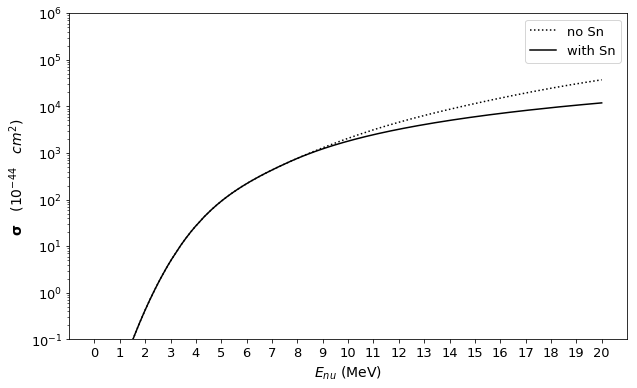

In [34]:
plt.figure(figsize=(10,6))
#plt.plot(Energy_all_fluxes, sigma_best_fit_full, ls=':', c='r', label='cross-section with only best_fit_full')
#plt.plot(Energy_all_fluxes, sigma_best_fit_Sn, ls=':', c='orange', label='cross-section with only best_fit_Sn')
plt.plot(Energy_all_fluxes, sigma_no_border_full, ls=':', c='black', 
         label='no Sn')
plt.plot(Energy_all_fluxes, sigma_border_full, ls='-', c='k', 
         label='with Sn')
plt.xlabel('$E_{nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad ( 10^{-44} \quad cm^2)$', fontsize=14)

plt.yscale('log')
plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(-1), 10**(6))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_section_best_fit_5_Sn_norm19.png', format='png', dpi=500)

SNU с Sn

In [35]:
rate_calc(sigma_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

f17   0.0017768671739810291
hep   0.17715348581421464
b8   41.435691794689895
pp   0.0
o15   0.06981219979904106
n13   0.016793521200135397
pep   0.1101191511102414
Be   0.3082293572815671
rate_total   42.11957637706907


SNU без Sn

In [36]:
rate_calc(sigma_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

f17   0.0017768671739810291
hep   0.2871943654419273
b8   48.979480264850515
pp   0.0
o15   0.06981219979904106
n13   0.016793521200135397
pep   0.1101191511102414
Be   0.3082293572815671
rate_total   49.773405726857405


### данные из графика BGT

In [37]:
bgt_full = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_bgt_full.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
bgt_0_5 = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_bgt_0_5l.csv', 
                      sep=';', decimal=',', names=['x', 'y'])

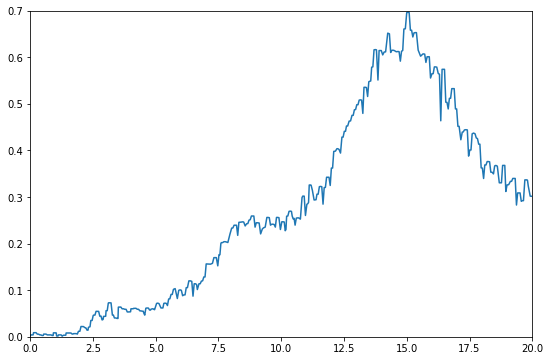

In [38]:
bgt = bgt_0_5.append(bgt_full[bgt_full['x']>5])

plt.figure(figsize=(9,6))
plt.plot(bgt['x'].values, bgt['y'].values)
plt.xlim(0,20)
plt.ylim(0,0.7)
plt.show()

In [39]:
trapz(bgt['y'].values, bgt['x'].values)

5.463277472256921

(0, 7)

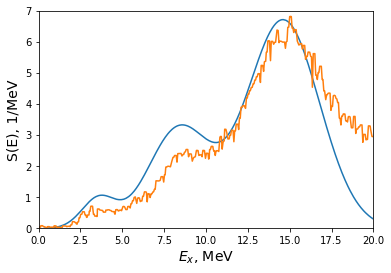

In [40]:
y_bgt = bgt['y'].values / trapz(bgt['y'].values, bgt['x'].values) \
* total_GT
y_bgt_border = border_func(bgt['x'].values, y_bgt, S_n)


plt.plot(best_fit['Ex, MeV'].values, y)
plt.plot(bgt['x'].values, y_bgt, )
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.xlim(0,20)
plt.ylim(0,7)
#plt.savefig('S_E_func_76Ge.png', format='png', dpi=400)


In [41]:
sigma_bgt_no_border_temp = [cross_sec(0,p, sigma_k_GTR, bgt['x'].values, y_bgt, 200) for p in p_list]

sigma_bgt_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_bgt_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [42]:
sigma_bgt_border_temp = [cross_sec(0,p, sigma_k_GTR, bgt['x'].values, y_bgt_border, 200) for p in p_list]

sigma_bgt_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_bgt_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

### BS05OP

In [43]:
rate_calc(sigma_bgt_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

f17   0.014034302708537179
hep   0.10864040126664977
b8   25.70856975850676
pp   0.0
o15   0.553607016385992
n13   0.16693835671447224
pep   0.8302972050993707
Be   2.9212454461204795
rate_total   30.303332486802258


In [44]:
rate_calc(sigma_bgt_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

f17   0.014034302708537179
hep   0.1923090370789622
b8   30.922363293771188
pp   0.0
o15   0.553607016385992
n13   0.16693835671447224
pep   0.8302972050993707
Be   2.9212454461204795
rate_total   35.600794657879


### BP98

In [45]:
rate_calc(sigma_bgt_border_full, BP98_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=BP98_pep, func_Be_ampl=BP98_Be,)

f17   0.015211838381000056
hep   0.028769841445140543
b8   23.268740642585207
pp   0.0
o15   1.264029754151707
n13   0.3289827550887808
pep   0.8127557148507923
Be   2.8971029217723765
rate_total   28.615593468275


In [46]:
rate_calc(sigma_bgt_no_border_full, BP98_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=BP98_pep, func_Be_ampl=BP98_Be,)

f17   0.015211838381000056
hep   0.0509267311306205
b8   27.987727761497652
pp   0.0
o15   1.264029754151707
n13   0.3289827550887808
pep   0.8127557148507923
Be   2.8971029217723765
rate_total   33.35673747687293


### BP98 OPAL92

In [47]:
rate_calc(sigma_bgt_border_full, BP98_OPAL92_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=BP98_OPAL92_pep, func_Be_ampl=BP98_OPAL92_Be,)

f17   0.015836653227613014
hep   0.028495842955186822
b8   24.57901924187641
pp   0.0
o15   1.31154966972132
n13   0.3398582180669223
pep   0.8127557148507923
Be   2.9816017569907376
rate_total   30.06911709768898


In [48]:
rate_calc(sigma_bgt_no_border_full, BP98_OPAL92_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=BP98_OPAL92_pep, func_Be_ampl=BP98_OPAL92_Be,)

f17   0.015836653227613014
hep   0.05044171464366222
b8   29.563735732533434
pp   0.0
o15   1.31154966972132
n13   0.3398582180669223
pep   0.8127557148507923
Be   2.9816017569907376
rate_total   35.075779460034475


### B16-GS98 (hight metallicity)

In [49]:
rate_calc(sigma_bgt_border_full, B16_GS98_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=B16_GS98_pep, func_Be_ampl=B16_GS98_Be,)

f17   0.01271257899454823
hep   0.10932539749153407
b8   24.669383283206844
pp   0.0
o15   0.48707913458853364
n13   0.15116893539616705
pep   0.8419915319317562
Be   2.9755661259037116
rate_total   29.2472269875131


###  B16-AGSS09met (low metallicity)

In [50]:
rate_calc(sigma_bgt_border_full, B16_AGSS09met_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=B16_AGSS09met_pep, func_Be_ampl=B16_AGSS09met_Be,)

f17   0.0078342169229163
hep   0.11302437710590928
b8   20.331909299346297
pp   0.0
o15   0.34214339210121386
n13   0.11092972237704345
pep   0.8536858587641417
Be   2.7160339891616028
rate_total   24.475560855779122


## Матричные элементы от ЮС

In [45]:
En = np.array([0.2, 0.54, 1.58, 1.97, 2.76, 3.08, 3.45, 6.0, 8.34, 14.8, 20.59, 20.94, \
               21.09, 21.22, 29.70])

Mn = np.array([0.0025, 0.0025, 0.01, 0.01, 0.02, 0.10, 0.01, 0.2, 1.2, 30.8, 0.5, 0.8, \
               0.5, 1.03, 6.3])

np.sum(Mn)

41.485

In [47]:
def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

Ex = np.arange(0,40,0.01)
w = En
M_square = Mn
alpha = 0.018


norm_factors = []
for w_i,M_i in zip(w, M_square):
    y_values = breit_vigner3(Ex, 1, w_i, alpha*w_i**2)
    norm_factors.append(trapz(y_values, Ex))

In [48]:
plots = np.zeros((w.shape[0], Ex.shape[0]))
for idx, w_i, M_i, norm_i in zip(range(w.shape[0]), w, M_square, norm_factors):
    amplitude = M_i / norm_i
    y_values = breit_vigner3(Ex, amplitude, w_i, alpha*w_i**2)
    plots[idx] = y_values
    
summ = np.sum(plots, axis=0)

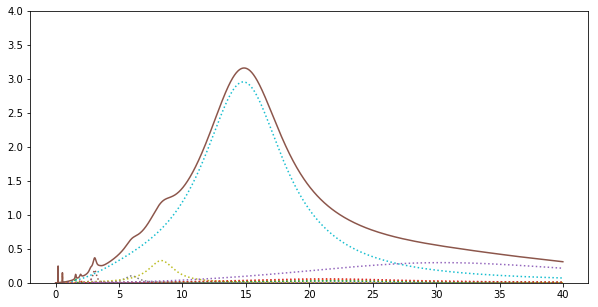

In [52]:
plt.figure(figsize=(10,5))
plt.ylim(0,4)
for elem in plots:
    plt.plot(Ex, elem, ls=':')
plt.plot(Ex, summ)
plt.show()

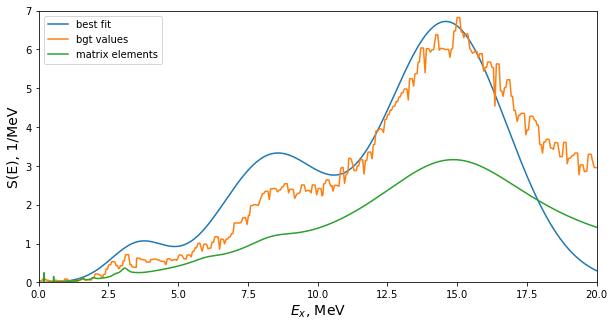

In [54]:
plt.figure(figsize=(10,5))
plt.plot(best_fit['Ex, MeV'].values, y, label='best fit')
plt.plot(bgt['x'].values, y_bgt, label='bgt values')
plt.plot(Ex, summ, label='matrix elements')
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.xlim(0,20)
plt.ylim(0,7)
plt.legend()
plt.show()